# Time Series Forecasting Competition

**Section 1: Choose Data**

In [50]:
## Read only
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error #run 'pip install scikit-learn' if not installed
from statsmodels.tsa.api import Holt, ExponentialSmoothing #run 'pip install statsmodels' in terminal if required
from statsmodels.tsa.ar_model import AutoReg #'pip install statsmodels' if required
from statsmodels.tsa.arima.model import ARIMA #'pip install statsmodels' if required
from statsmodels.tsa.statespace.sarimax import SARIMAX #'pip install statsmodels' if required
from statsmodels.tsa.stattools import adfuller #'pip install statsmodels' if required
from statsmodels.tsa.seasonal import seasonal_decompose #'pip install statsmodels' if required
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #'pip install statsmodels' if required

Edit point 1: Choose your data of interest!!!

In [51]:
## Edit Point 1
#Select data you are interested in, by typing relevant csv name in below in place of random_number_data.csv, 
#random_number_data.csv used by default

#read csv file to pd dataframe
data_df = pd.read_csv('jena_climate_data.csv')

##Then filter to just relevant Date column name plus one Column of interest, may need to change name of Date column to 
#Date Time for some datasets
data_df = data_df[['Date Time','T (degC)']]

#Additional cleaning/ processing required for some datasets, e.g. if using avocado_price_and_sales_volume_data, it is
#grouped by region and type, so use groupby to look at aggregates for one day (or filter to one state and type) 

data_df.head()

,Date Time,T (degC)
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


In [52]:
## Read only (unless you are using Jena climate data, in which case comment out current code and uncomment lower line)
#ensure datetime in correct format (adjust as neccessary for chosen dataset)

# data_df['Date']=pd.to_datetime(data_df['Date'], dayfirst=True, format="%d/%m/%Y") # works for random number, gold price,
# 

# #Uncomment for jena_climate data
data_df['Date Time']=pd.to_datetime(data_df['Date Time'], dayfirst=True, format="%d.%m.%Y %H:%M:%S")



In [53]:
## Read only change to Date Time or other if needed
#Set datetime to index
data_df = data_df.set_index('Date Time')

data_df.head()


,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


**Section 2: View Data and Choose Sample Rate**

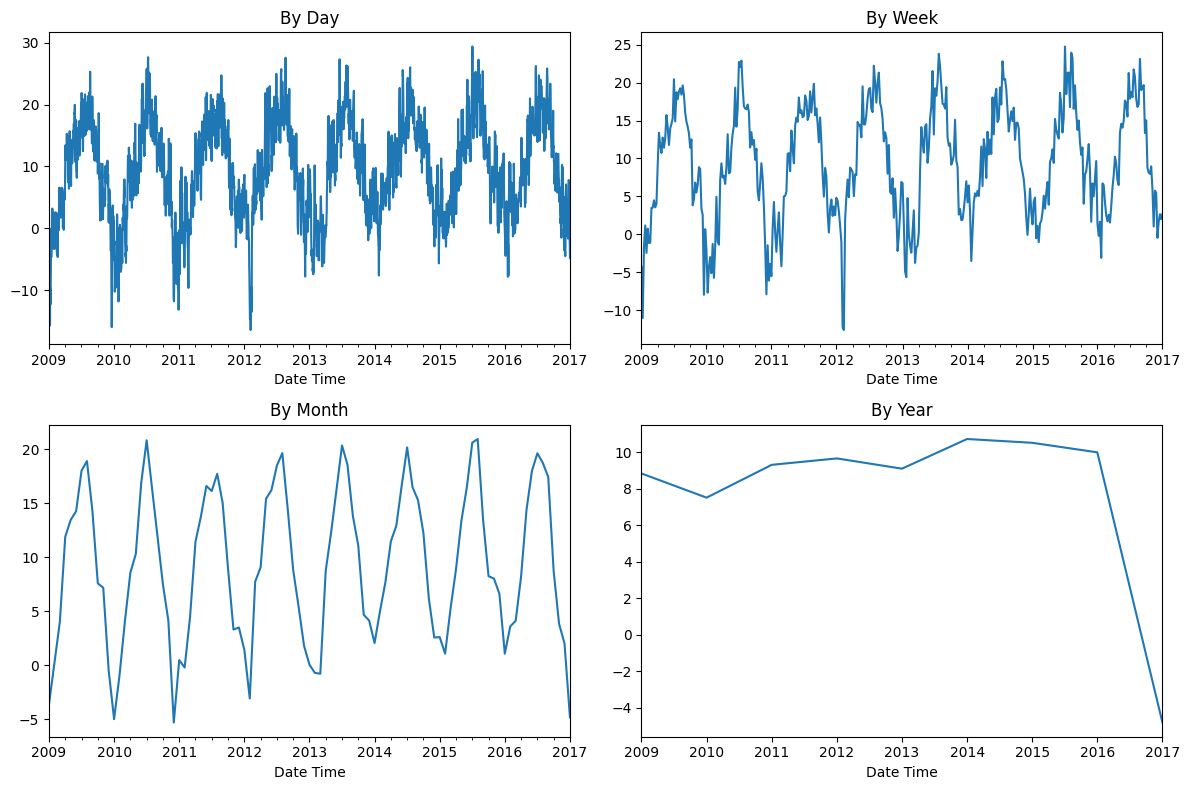

In [54]:
## Read only
#plot at different sample rates (feel free to play with viewing at different sample rates in these graphs if you wish)
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8))

data_df['T (degC)'].resample('d').mean().plot(ax=ax[0,0]) # group by day
data_df['T (degC)'].resample('w').mean().plot(ax=ax[0,1]) # group by month
data_df['T (degC)'].resample('m').mean().plot(ax=ax[1,0]) # group by quarter
data_df['T (degC)'].resample('a').mean().plot(ax=ax[1,1]) # group by year

ax[0,0].set_title('By Day')
ax[0,1].set_title('By Week')
ax[1,0].set_title('By Month')
ax[1,1].set_title('By Year')

fig.tight_layout()
plt.show()

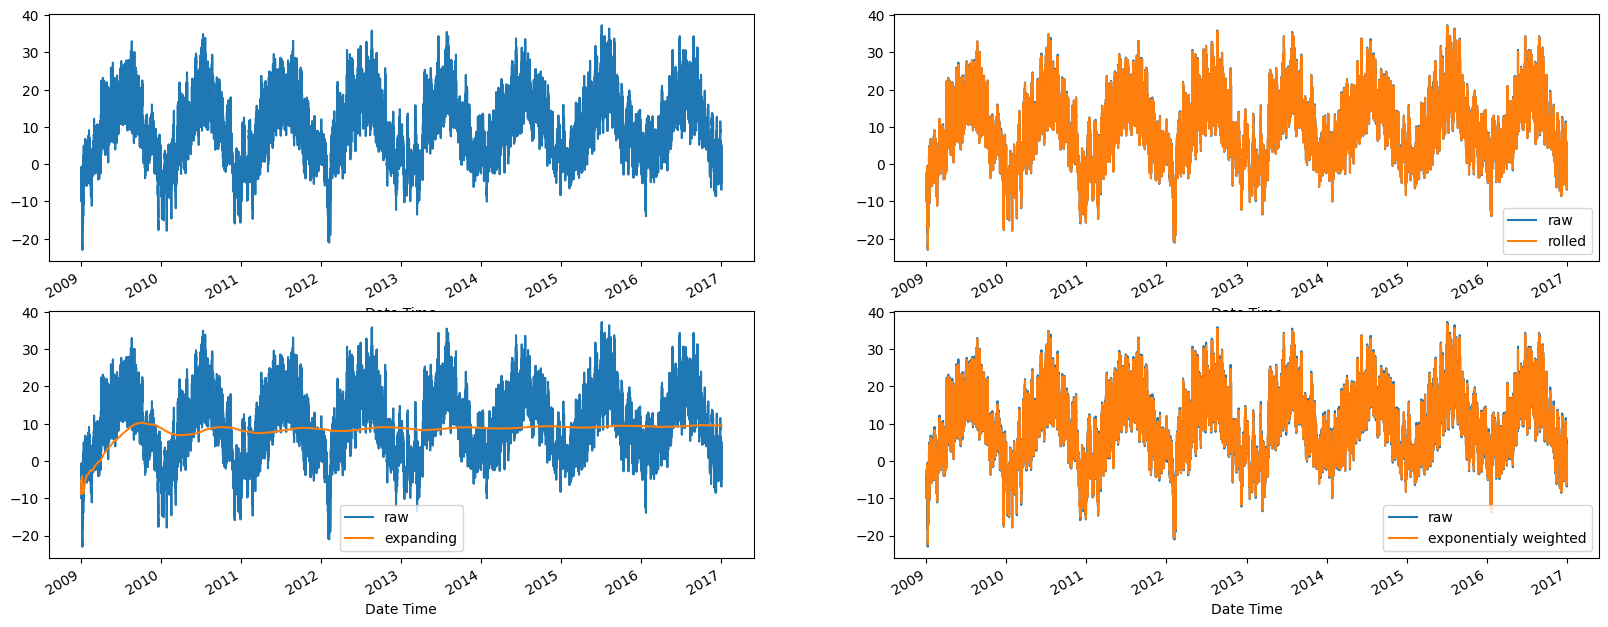

In [55]:
## Read only
#Plots smoothed data, using rolled, expanding and exponentially weighted methods, to help inform sample rate decision
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,8))
data_df['T (degC)'].plot(ax=ax[0,0],label='raw')
data_df['T (degC)'].plot(ax=ax[0,1],label='raw')
data_df[['T (degC)']].rolling(window=5, center= True).mean()['T (degC)'].plot(ax=ax[0,1],label='rolled')
data_df['T (degC)'].plot(ax=ax[1,0],label='raw')
data_df[['T (degC)']].expanding().mean()['T (degC)'].plot(ax=ax[1,0],label='expanding')
data_df['T (degC)'].plot(ax=ax[1,1],label='raw')
data_df[['T (degC)']].ewm(span=10).mean()['T (degC)'].plot(ax=ax[1,1],label='exponentialy weighted')
ax[1,0].legend()
ax[1,1].legend()
ax[0,1].legend()
plt.show()

Edit point 2: Choose your sample rate!!!

In [56]:
## Edit point 2:
#Resample data to appropriate chosen sample rate in below expression (by default this is set to monthly)
data_df=data_df.resample('m').mean()  #'D' for daily, 'w' for weekly, 'm' for monthly, 'q' for quarterly, 'a' for annual

**Section 3: Check for a linear trend**

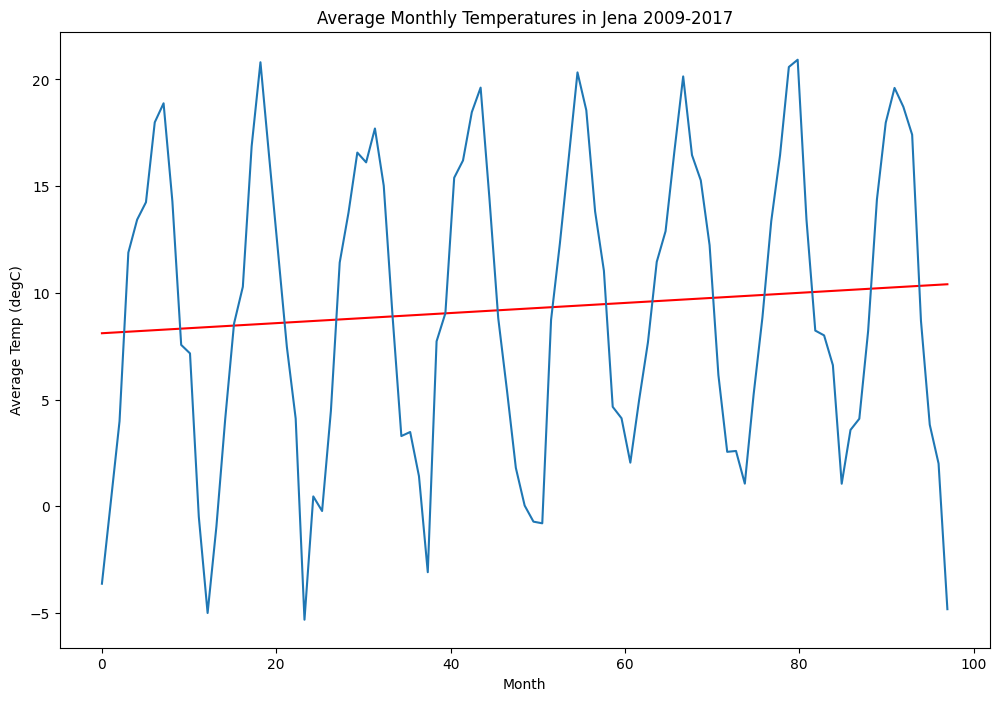

In [57]:
## Read only
#Plots data alongside trend line to view visually
fig, ax = plt.subplots(figsize=(12,8)) # this line sets the size of the visualisation

data_points=np.linspace(0,len(data_df),num=len(data_df)) # Creates list of data points as long as dataframe
line_coef = np.polyfit(data_points,data_df['T (degC)'],1) # Finds the trendline of the scores
polynomial = np.poly1d(line_coef) # Function that for any independent variable given, will return the dependent variable

ax.plot(data_points, polynomial(data_points),c='red') #plots the trendline
ax.plot(data_points,data_df['T (degC)']) # this plots the data

ax.set_title('Average Monthly Temperatures in Jena 2009-2017')
ax.set_ylabel('Average Temp (degC)')
ax.set_xlabel('Month')
plt.show()

Edit point 3: Determine whether there is a statistically significant linear trend in the data

In [58]:
#Prints p-value of Augmented Dickie Fuller test on chosen data, test at 95% significance level
result = adfuller(data_df['T (degC)']) # https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
print('p-value: ' +str(result[1])) # null hypothesis that a unit root is present in a time series sample

## Edit point 3:

#P value > 0.05 so fail to reject null hypothesis (conclude data is not stationary) - differencing required for 
#models where data must be stationary

p-value: 0.3780443683427458


**Section 4: Check for Seasonality**

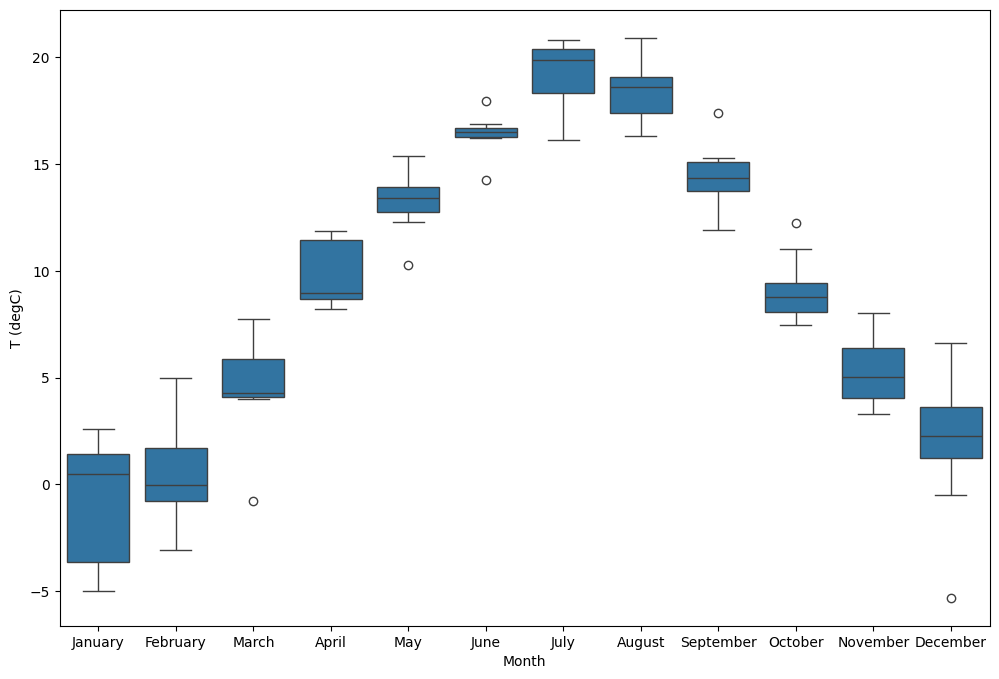

In [59]:
## Read only (unless you need or want to look at a different seasonal sample rate to monthly)
#Plot boxplot to visually assess seasonality (feel free to play around with viewing at different sample rates as you see 
#fit, for example on a week by week or day by day basis)
data_df['Month']=data_df.index.month_name()

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Month',y='T (degC)',data=data_df, ax=ax,
            order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                   'November', 'December'])

plt.show()

<Figure size 640x480 with 0 Axes>

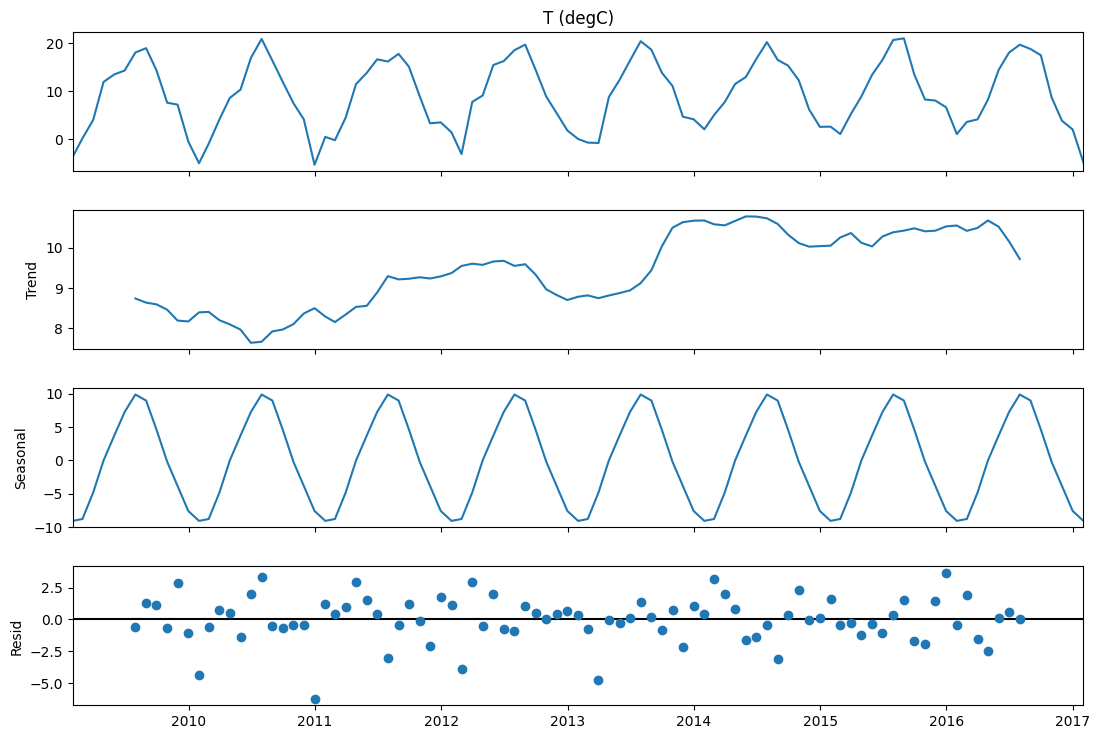

In [60]:
##Read Only (unless you need or want to look at a different seasonal sample rate: Hint - You may want to mess around 
#with seasonal period if you have not gone for a monthly sample rate).
#Plots raw data, trend, seasonal decomposition and residuals
decompose = seasonal_decompose(data_df['T (degC)'], period=12) 

fig = plt.figure()  
fig = decompose.plot() 
fig.set_size_inches((12, 8))
plt.show()

#Trend: Shows any trend in the data which may need to be considered in a forecasting model (seasonality removed)

#Seasonal: Shows any seasonally recurring pattern that may need to be considered in a forecasting model (trend removed)

#Residuals: The residual graph shows the pattern that remains once trends and seasonality have both been removed from 
#the data and should in theory remain constant over time. Any significant fluctuations in the residuals could indicate 
#that there would be additional factors not accounted for by a time series model of the data, even if it were to 
#consider both trends and seasonality

In [61]:
#Edit Point 4: Determine visually if there is a significant seasonal trend based on the above graphs. Then select the 
#appropriate YES or NO statement below and delete the other:

#a: Yes, there is a significant seasonal trend that needs to be considered in the model

#If Yes is selected above, what is the order of the seasonal trend? (Fill in number below):
#If no is selected above, comment out cell below

#To determine seasonal order, as an example, if the sample rate is monthly and there is an annually recurring pattern, 
#order would be 12. If sample rate was daily and there was a weekly recurring pattern, order would be 7, etc*. If still
#unsure after this section, come back following producing the ACF and PACF plots. 
#Set seasonal_observations to this number in the variable below

seasonal_observations=12 #As sample rate is monthly and there is an annually recurring pattern

**Section 5: Choose Train-Test Split**

Edit point 5: Adjust the train-test split below as appropriate

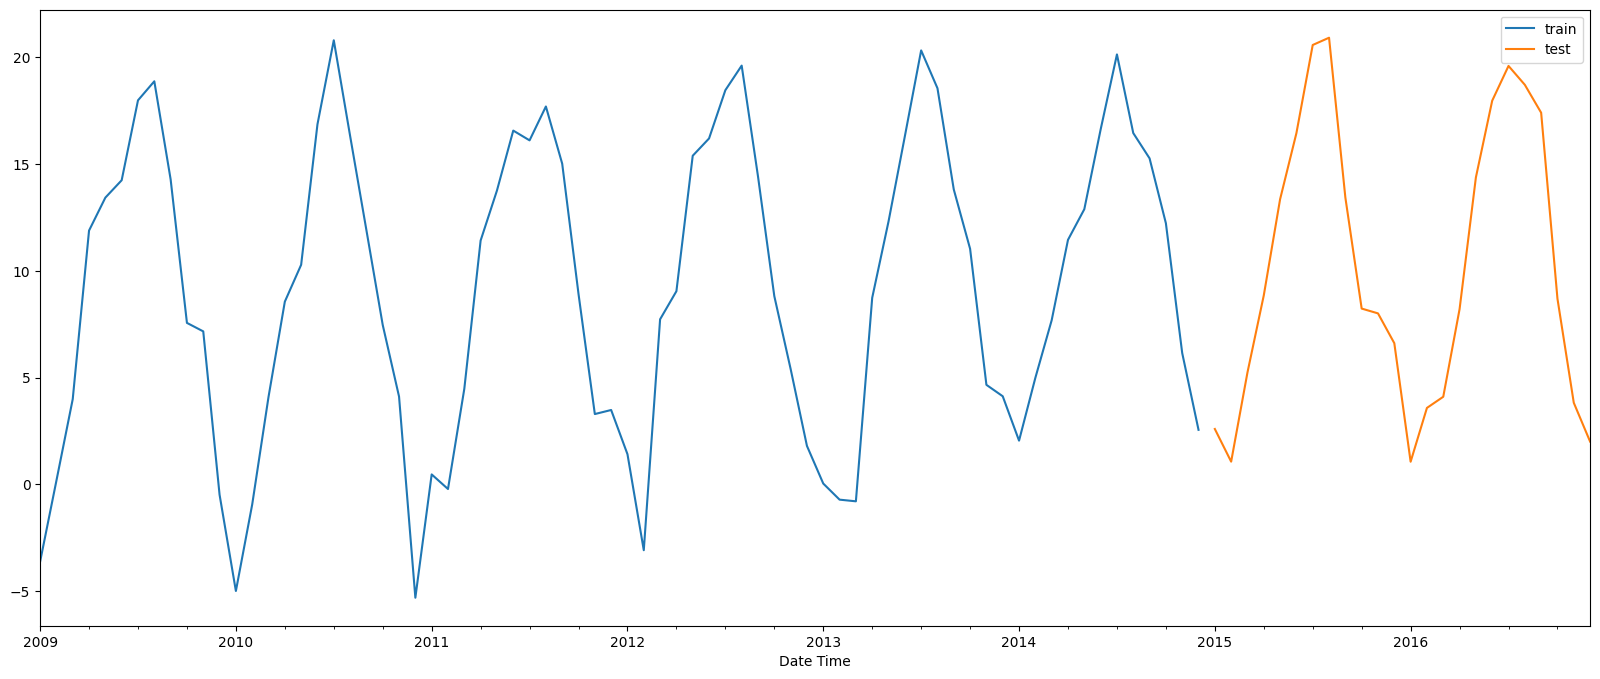

In [62]:
##Edit point 5: Select your train-test split for the forecasting model.
#Select the split of data into the train and test data you would like in your model. (By default I have set this to 
#training on 2019 to 2022 and testing on 2023 data, which is roughly an 80:20 split. Be aware if you adjust this that 
#you need at least two full seasonal cycles, in the training set, to make forecasting models accounting for seasonality 
#accurate).
train=data_df.loc['2009':'2014'] #Creates the training set, to build the model from from this selection of data
test=data_df.loc['2015':'2016'] #Creates the test set, to assess the performance of the model on, before it is deployed to 
#a future forecast

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test['T (degC)'].plot(ax=ax,label='test')
plt.legend()
plt.show()

**Section 6: ACF Plot and Determine MA Model Order**

Autocorrelation:

Autocorrelation is the influence of a data point on a subsequent data point. An ACF plots this at different lags

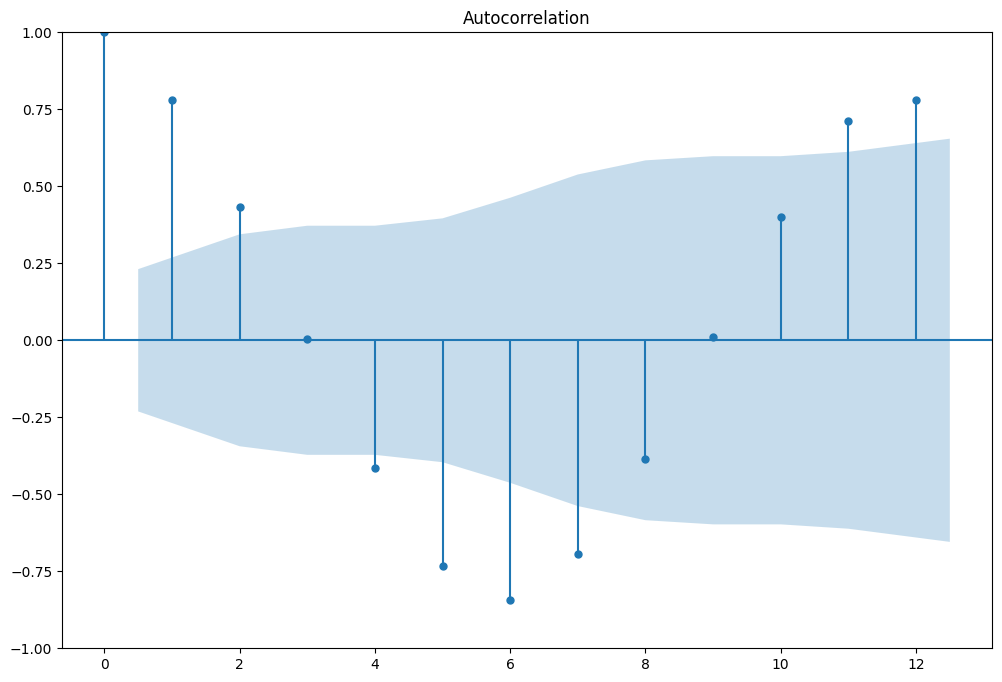

In [63]:
##Read only - unless you are at a different sample rate, in which case plot graph for same number of lags as your 
#seasonal order at your sample rate (or greater)

# plot  autocorrelation for training data - do for lags up to seasonal period at least
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(train['T (degC)'], lags=12,ax=ax) 
plt.show()

In [64]:
#Edit Point 6:

#The order of a moving average model can be found by looking at the number of statistically significant  lags in an 
#autocorrelation function plot (ACF)

#As shown by your ACF graph above, edit the ma_order variable value below and write in the Moving Average order: 
ma_order=2


**Section 7: PACF Plot and Determine AR Model Order**

Partial Autocorrelation (PACF):

A PACF graph looks at the correlation between observations, whilst also controlling for the lags that fall in between. 

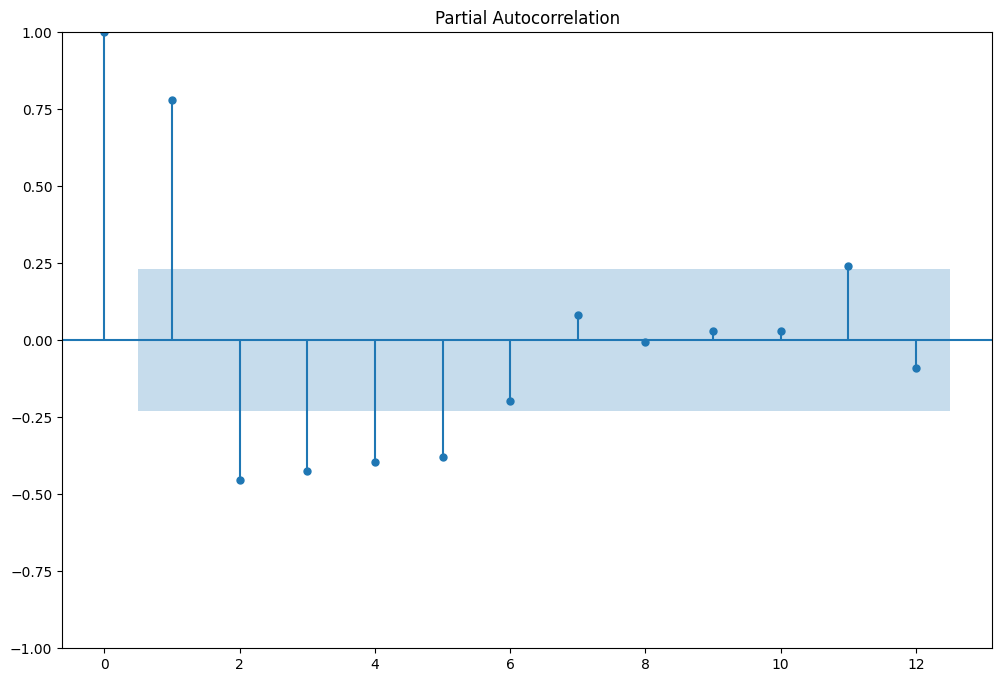

In [65]:
##Read only - unless you are at a different sample rate, in which case plot graph for same number of lags as your 
#seasonal order at your sample rate (or greater)

# plot partial autocorrelation for data aggregated by month (12 lags for 1 year)
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(train['T (degC)'], lags=12,ax=ax, method='ywm') 
plt.show()

In [70]:
#Edit Point 7:

#The autoregressive order for an autoregressive model can be found by identifying the number of statistically 
#significant non-zero lags on a Partial Autocorrelation Function (PACF) graph.

#As shown by your PACF graph above, edit the ar_order variable value below and write in the autoregressive order: 
ar_order=5


**Section 8: Model Selection**

**Select Models To Investigate and parameters for those models based on your findings above, the following and any extra info from the ppt:**

**Naive Forecast**: This is a baseline model that doesn't consider trend, seasonality, autocorrelation etc... just predicts future values from the final observed value

**Holt linear forecast**: Will consider any kind of trend in the data. Autocorrelation, and any seasonality, are not considered again.

**Holt-Winter Exponential Smoothing (HWE)**: Considers seasonality as well as trend. Still does not consider autocorrelation

**Autoregressive Model (AR)**: A simple autoregressive model has the advantage of considering how related the observations are to one another (autocorrelation) and will be effective at identifying patterns based off autocorrelations. These types of models do not however, consider trends or seasonality particularly effectively. They also require the data to be stationary. Order can be found from the number of significant lags in a PACF plot

**Moving Average Models (MA)**: These models can deal with slight trends of seasonality and are resistant to small random variations in the data. They do not cope well with rapid changes in the data and require a high degree of stationarity. Order can be found from the number of significant lags in an ACF plot

Important: The general guidance with AR and MA models is that if ACF shows the lags tailing off while the PACF shows a cut off after several significant lags then select an AR model. If the opposite is true, select an MA model

**ARIMA Models**: These combine the autoregressive and moving average elements to produce a combined model. They are effective at finding patterns in time series data based on differences in observations  and takes into account trends. However, don't handle seasonality well. Steps on parameter setting are detailed in the section 8f if you wish to pursue this more involved modelling method

**SARIMA Models**: These combine the autoregressive and moving average elements to produce a combined model and in addition consider seasonality. Therefore, they are effective at finding patterns in time series data based on differences in observations whilst taking into account seasonality. Steps on parameter setting are detailed in the section 8f if you wish to pursue this more involved modelling method. The steps to produce an ARIMA model first need to be taken to determine those parameters, and then further steps to find a set of seasonal parameters need to be taken.



Detrending and Differencing

**Section 8a: Niave Forecasting**

2.5529278673835125


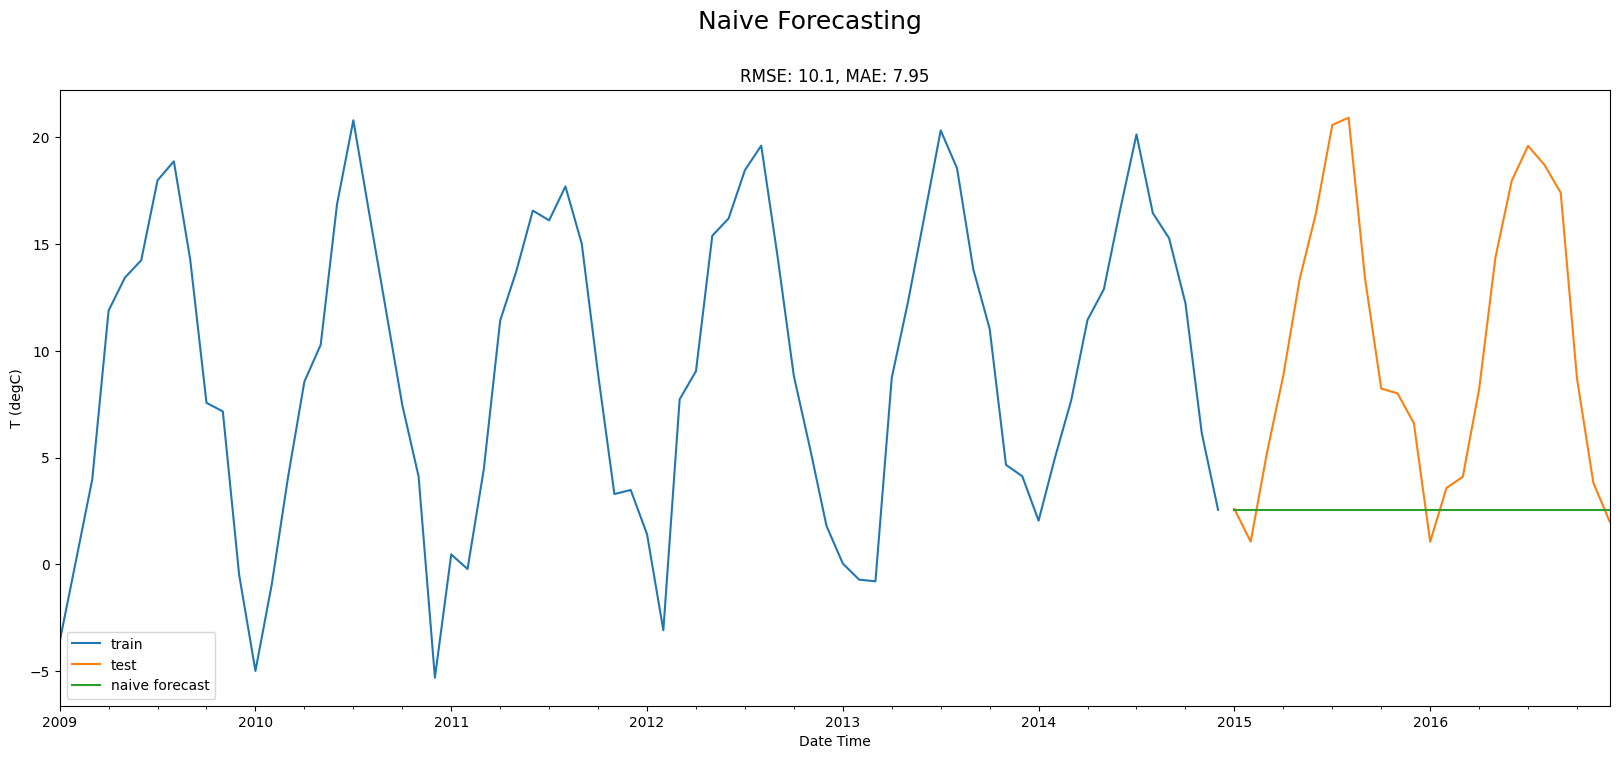

In [67]:
##Read only (but will be affected by where the train-test split is defined, so changing step 5 will change this model)
#Build the naive forecasting model
last_value=train['T (degC)'].iloc[-1] # identify last observed value
print(last_value)

test_naive=test.copy() # create test set for this example
test_naive['predicted']=last_value # for each observation in test set, assign forecast prediction of last_value

# calculate errors and round to 2 d.p
rmse_naive=round(np.sqrt(mean_squared_error(test_naive['T (degC)'],test_naive.predicted)),2)
mae_naive=round(mean_absolute_error(test_naive['T (degC)'],test_naive.predicted),2)

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test_naive['T (degC)'].plot(ax=ax,label='test')
test_naive.predicted.plot(ax=ax,label='naive forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_naive)+', MAE: '+str(mae_naive))
plt.suptitle('Naive Forecasting',fontsize=18)
plt.ylabel('T (degC)')
plt.show()

**Section 8b: Holt Linear Trend Forecasting**

Edit point 8b: Model can be adjusted by fiddling with smoothing level. Empirically change smoothing level and assessing when error scores are optimised to produce best model (values are between 0 and 1).

A smaller smoothing level gives more weight to recent observations, making the forecast more responsive to short-term fluctuations. On the other hand, a larger smoothing level provides more weight to older observations, resulting in a smoother forecast. However, blindly aiming for the least or most amount of smoothing is not always optimal. If the data contains high noise or volatility, excessive smoothing may lead to underfitting, resulting in overly simplistic forecasts. Conversely, too little smoothing might result in overfitting, making the forecasts overly responsive to noise or short-term fluctuations.
 

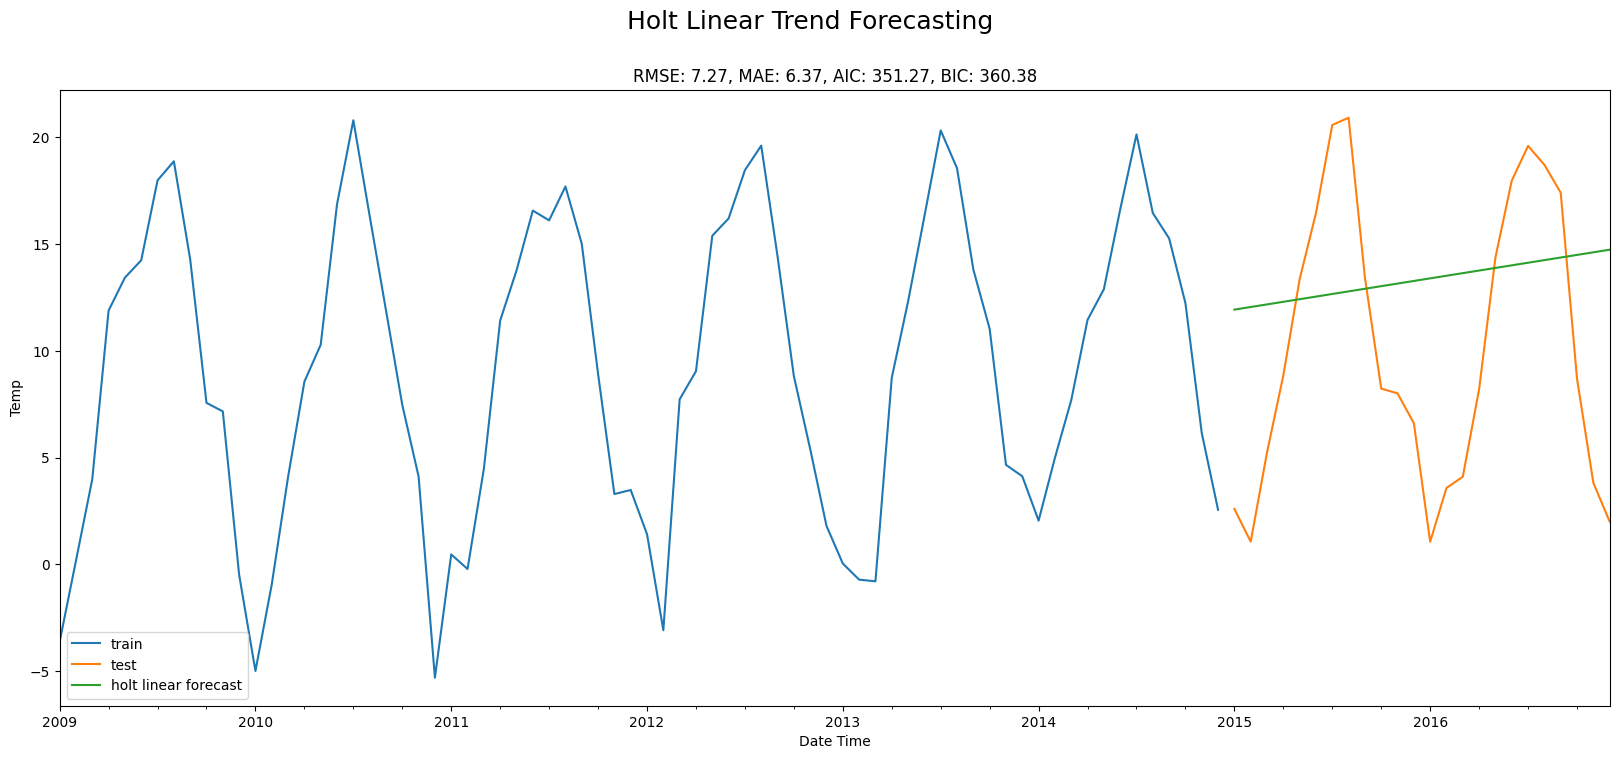

In [68]:
#Edit point 8b: Set smoothing level

# create Holt model
# Additionally, if your data is showing an exponential trend (not linear), set exponential=True
holt = Holt(train['T (degC)'],exponential=False).fit(optimized=True, smoothing_level=0.12) 
# experiment with smoothing level until convergence warning disappears and based on judgement and the above comments

test_holt=test.copy() # create test set for this example
test_holt['predicted']=holt.forecast(len(test_holt)) # for each observation in test set, assign holt forecast

# calculate errors and round to 2 d.p
rmse_holt=round(np.sqrt(mean_squared_error(test_holt['T (degC)'],test_holt.predicted)),2)
mae_holt=round(mean_absolute_error(test_holt['T (degC)'],test_holt.predicted),2)

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test_holt['T (degC)'].plot(ax=ax,label='test')
test_holt.predicted.plot(ax=ax,label='holt linear forecast')
aic_holt=round(holt.aic,2)
bic_holt=round(holt.bic,2)
plt.legend()
plt.title('RMSE: '+str(rmse_holt)+', MAE: '+str(mae_holt)+', AIC: '+str(aic_holt) + ', BIC: '+str(bic_holt))

plt.suptitle('Holt Linear Trend Forecasting',fontsize=18)
plt.ylabel('Temp')
plt.show()

**Section 8c: Holt-Winter Exponential Smoothing (HWE) Forecasting**  

Edit point 8c: Seasonal period needs to be set based off your earlier analysis, this has been set by default at 12 which would be appropriate for an annually repeating cycle with a monthly sample rate. Adjust as needed

As with 8b (Holt Linear), Model can still be adjusted by fiddling with smoothing level. Empirically change smoothing level and assessing when error scores are optimised to produce best model (values for smoothing level are between 0 and 1)

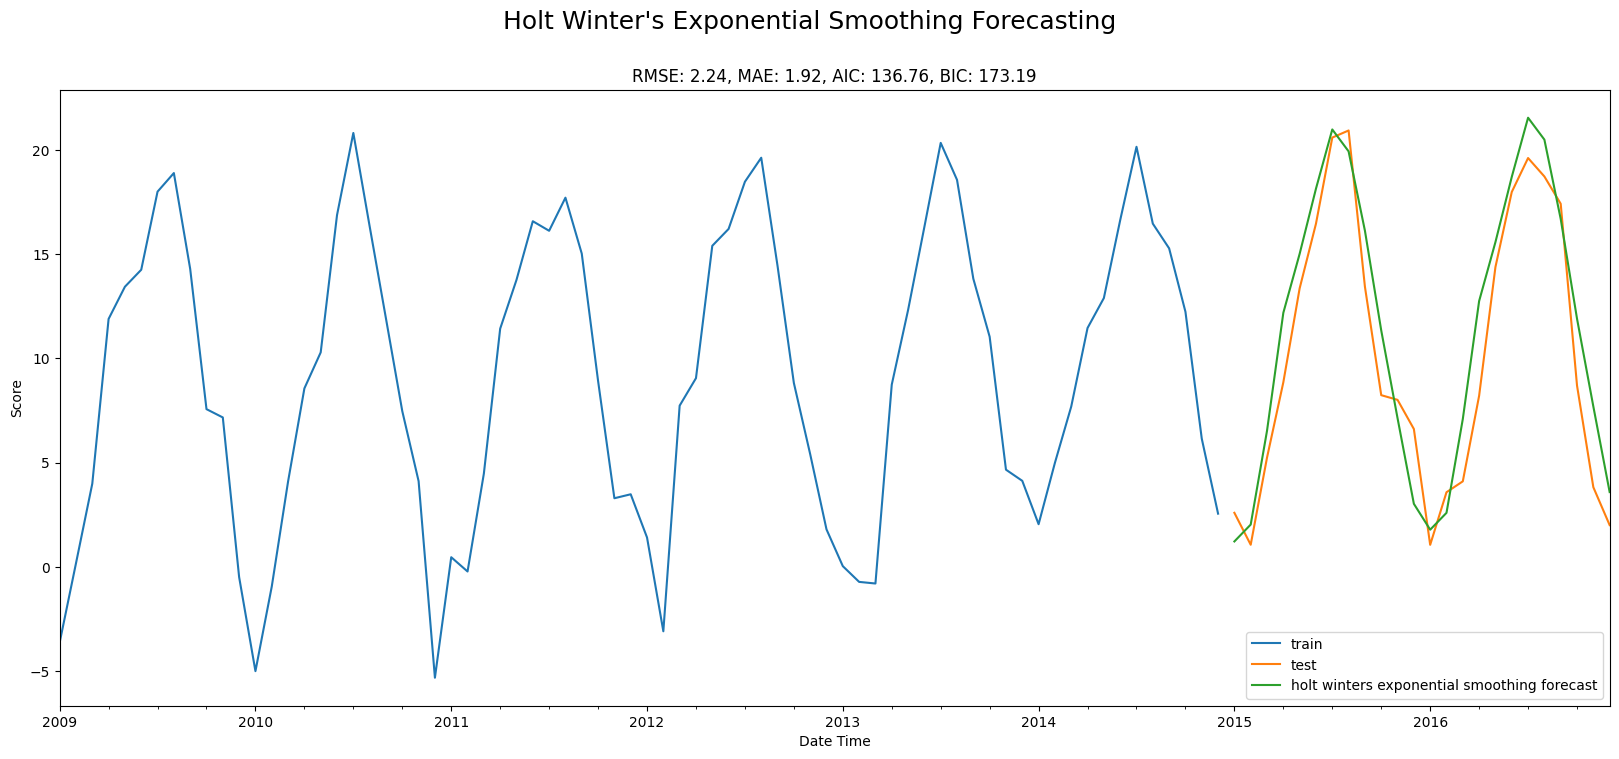

In [69]:
#Edit point 8c: Set seasonal period to same as answer to Edit Point 4 in section 4. If answer there was NO seasonal 
#trend, then model is unlikely to be appropriate.

# create Holt Winter's model (as weekly data, set seasonal period to 52 with linear trend)
hwes = ExponentialSmoothing(train['T (degC)'],seasonal_periods=12 ,trend='add', 
                            seasonal='add').fit(optimized=True,smoothing_level=0.5)
# play around with smoothing_level until you get something that works

test_hwes=test.copy() # create test set for this example
test_hwes['predicted']=hwes.forecast(len(test_hwes)) # for each observation in test set, assign holt winter's forecast

# calculate errors and round to 2 d.p
rmse_hwes=round(np.sqrt(mean_squared_error(test_hwes['T (degC)'],test_hwes.predicted)),2)
mae_hwes=round(mean_absolute_error(test_hwes['T (degC)'],test_hwes.predicted),2)
aic_hwes=round(hwes.aic,2)
bic_hwes=round(hwes.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test_hwes['T (degC)'].plot(ax=ax,label='test')
test_hwes.predicted.plot(ax=ax,label='holt winters exponential smoothing forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_hwes)+', MAE: '+str(mae_hwes)+', AIC: '+str(aic_hwes)+', BIC: '+str(bic_hwes))
plt.suptitle("Holt Winter's Exponential Smoothing Forecasting",fontsize=18)
plt.ylabel('Score')
plt.show()

**Section 8d: Autoregressive Forecasting**  

Edit point 8d: Order needs to be set based off your earlier PACF plot, with order set to the number of significant lags

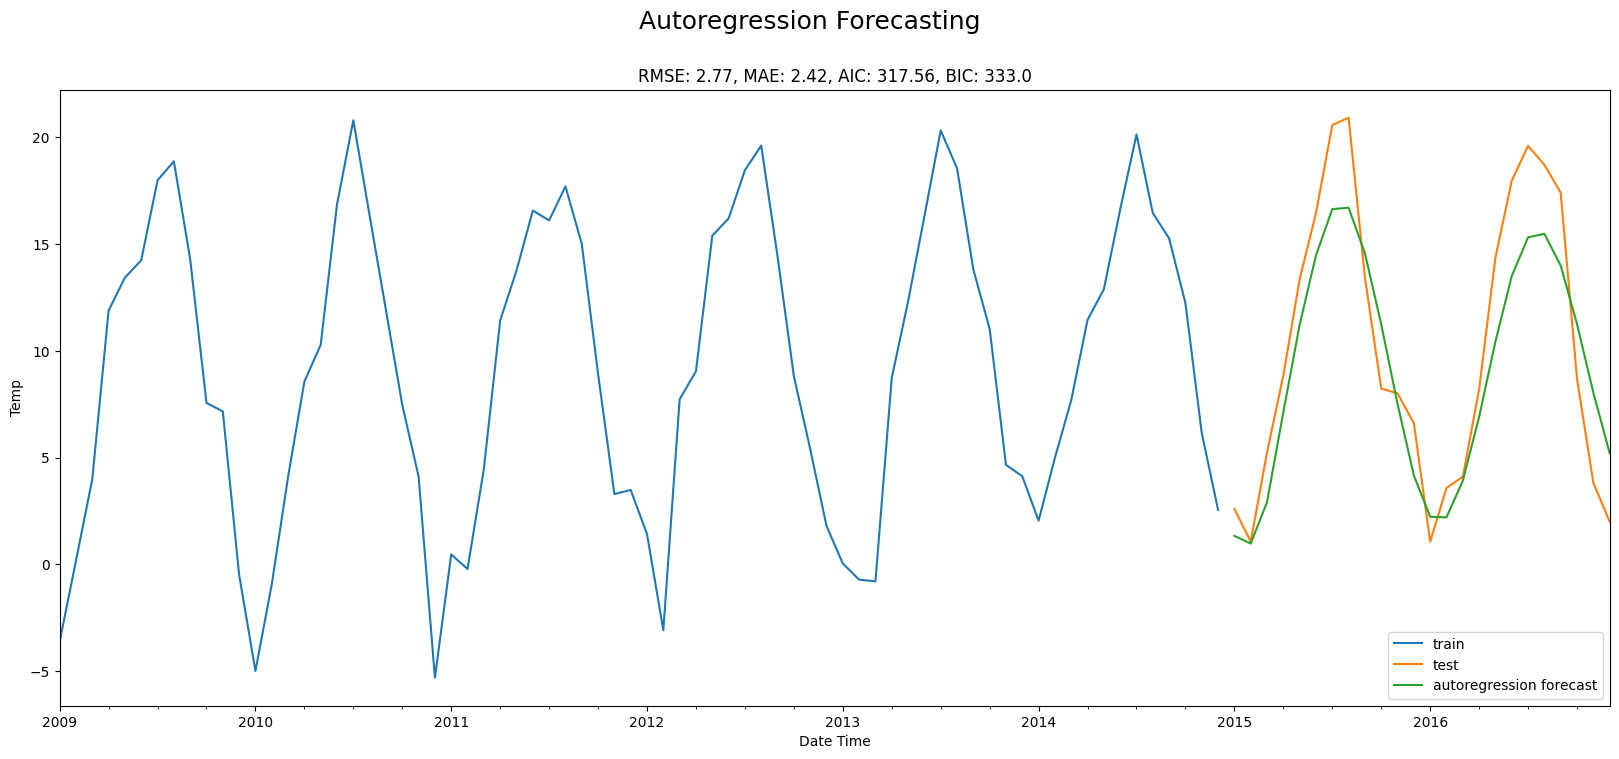

In [72]:
#Edit point 8d: Set order to same as edit point 6 answer: Significant non zero lags in the PACF plot

# create AutoReg model with 2 lags
ar = AutoReg(train['T (degC)'],lags=ar_order).fit()

test_ar=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ar['predicted']=ar.predict(start=test_ar.index[0],end=test_ar.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ar=round(np.sqrt(mean_squared_error(test_ar['T (degC)'],test_ar.predicted)),2)
mae_ar=round(mean_absolute_error(test_ar['T (degC)'],test_ar.predicted),2)
aic_ar=round(ar.aic,2)
bic_ar=round(ar.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test_ar['T (degC)'].plot(ax=ax,label='test')
test_ar.predicted.plot(ax=ax,label='autoregression forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ar)+', MAE: '+str(mae_ar)+', AIC: '+str(aic_ar)+', BIC: '+str(bic_ar))
plt.suptitle("Autoregression Forecasting",fontsize=18)
plt.ylabel('Temp')
plt.show()

**Section 8e: Moving Average Forecasting**  

Edit point 8e: Order needs to be set based off your earlier ACF plot, with order set to the number of significant non zero lags

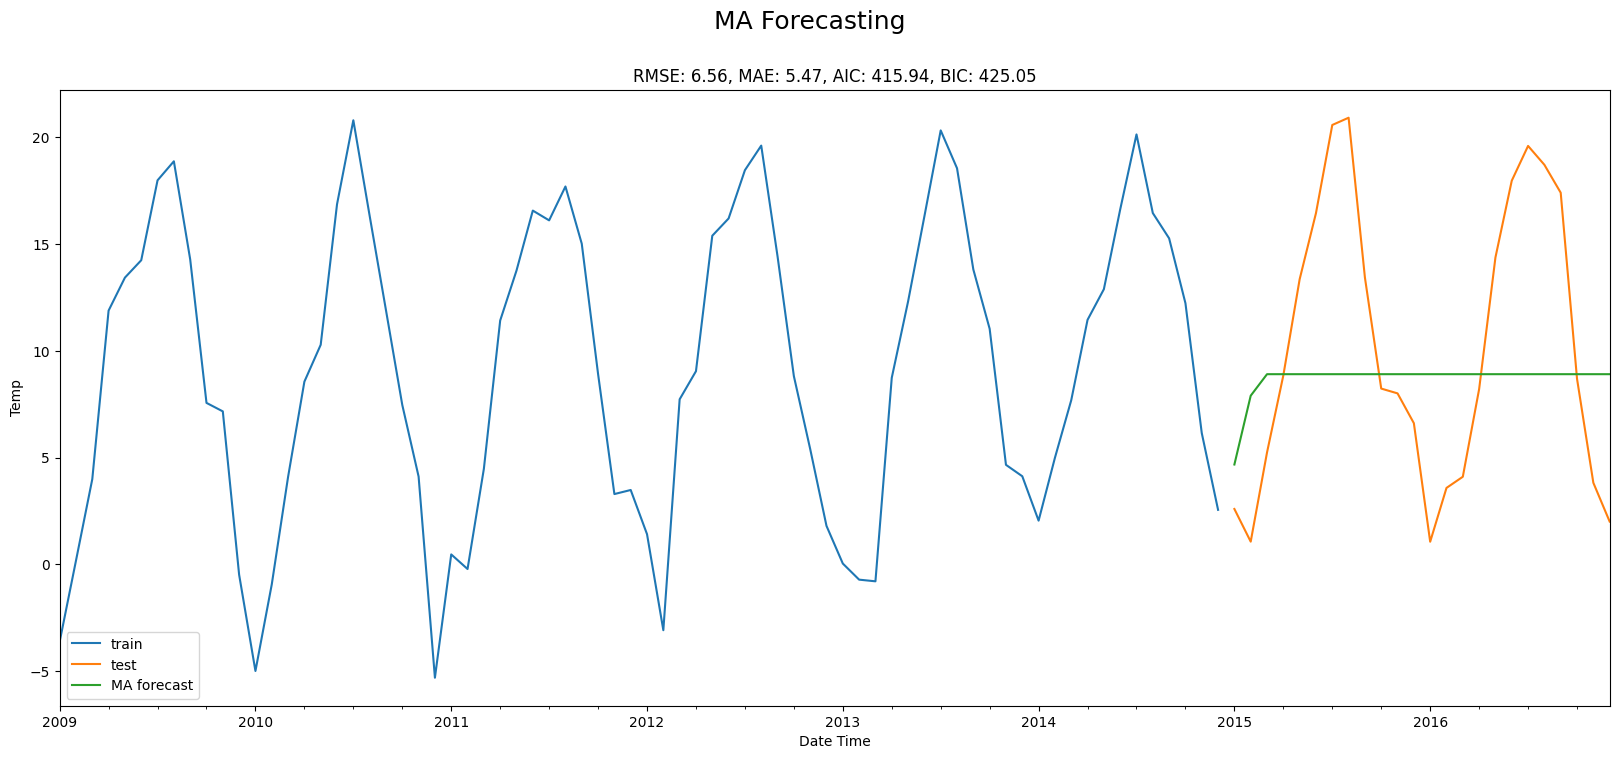

In [73]:
#Edit point 8e: Set order to same as edit point 7 answer: Significant non zero lags in the ACF plot

# create MA model with order 5
ma = ARIMA(train['T (degC)'],order=(0,0,ma_order)).fit()

test_ma=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ma['predicted']=ma.predict(start=test_ma.index[0],end=test_ma.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ma=round(np.sqrt(mean_squared_error(test_ma['T (degC)'],test_ma.predicted)),2)
mae_ma=round(mean_absolute_error(test_ma['T (degC)'],test_ma.predicted),2)
aic_ma=round(ma.aic,2)
bic_ma=round(ma.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train['T (degC)'].plot(ax=ax,label='train')
test_ma['T (degC)'].plot(ax=ax,label='test')
test_ma.predicted.plot(ax=ax,label='MA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ma)+', MAE: '+str(mae_ma)+', AIC: '+str(aic_ma)+', BIC: '+str(bic_ma))
plt.suptitle("MA Forecasting",fontsize=18)
plt.ylabel('Temp')
plt.show()

**Section 8f: ARIMA Models**

In [23]:
#Edit point 8f-1:
#Re-perform ADF test on training dataset to check for stationarity within that set

train_result = adfuller(train.Score)
print('p-value:' +str(result[1]))

#If <0.05 then data is stationary, set below (d=0)
d=0

#if >0.05 then fail to reject null hypothesis - data not stationary and needs to be adjusted, so comment out d=0 and 
#uncomment below code block


p-value:6.467632683314897e-14


In [24]:
#Edit point 8f-2 (if required):
# Create first order difference   ...Only use this code block if above result is >0.05
# train['difference'] = train.Score.diff(periods = 1)

# # Calculate new p-value
# result_diff = adfuller(train.difference.dropna())
# print('p-value:' +str(result[1]))
# # plot two charts for comparison

# fig, ax = plt.subplots(ncols=2,figsize=(20,8))
# train.Score.plot(ax=ax[0])
# ax[0].set_title('Raw p-value: '+str(result[1]))
# train.difference.plot(ax=ax[1])
# ax[1].set_title('1st order difference p-value: '+str(result_diff[1]))
# plt.show()

# #If this is successful, set d to 1 as below
# d=1

#If this is not successful, repeat the differencing process and assessment once more in a new codeblock underneath. If
#p<0.05 after that second set of differencing, set d=2. If it is still >0.05 after that, this is not an appropriate 
#method for the data

In [25]:
#Edit point 8f-3 (if required):

#If d=1 then ar_order and ma_order need to be recalculated from the differenced data (and if it equalled 2 from the 
#double differenced data). These graphs will display below if needed and 

if d==1:
    fig, ax = plt.subplots(ncols=2, figsize=(20,8))

    plot_acf(train.difference.dropna(),lags=20,ax=ax[0]) #acf and pacf don't handle null values
    plot_pacf(train.difference.dropna(),lags=20,ax=ax[1],method='ywm' )  #null values will occur in differenced data
    plt.show()

#If d=2 you'll need to write in the code to view the ACF and PACF from the double differenced data

In [26]:
# #Edit point 8f-4 (if required): Uncomment the below and set the new ar_order and ma_order values as appropriate
# ar_order=0
# ma_order=0

In [27]:
#Edit point 8f-5: Uncomment the relevant statement variable statement below if required

#We also need to look at whether the first significant lag on the ACF is positive or negative:

# # Positive: Definitely keep the AR terms, p = 1 , could /might drop the MA term (q=0)
# ma_order=0

# #Negative: Definitely keep the MA terms, q = 1, could/ might drop the AR term (p=0)
# ar_order=0

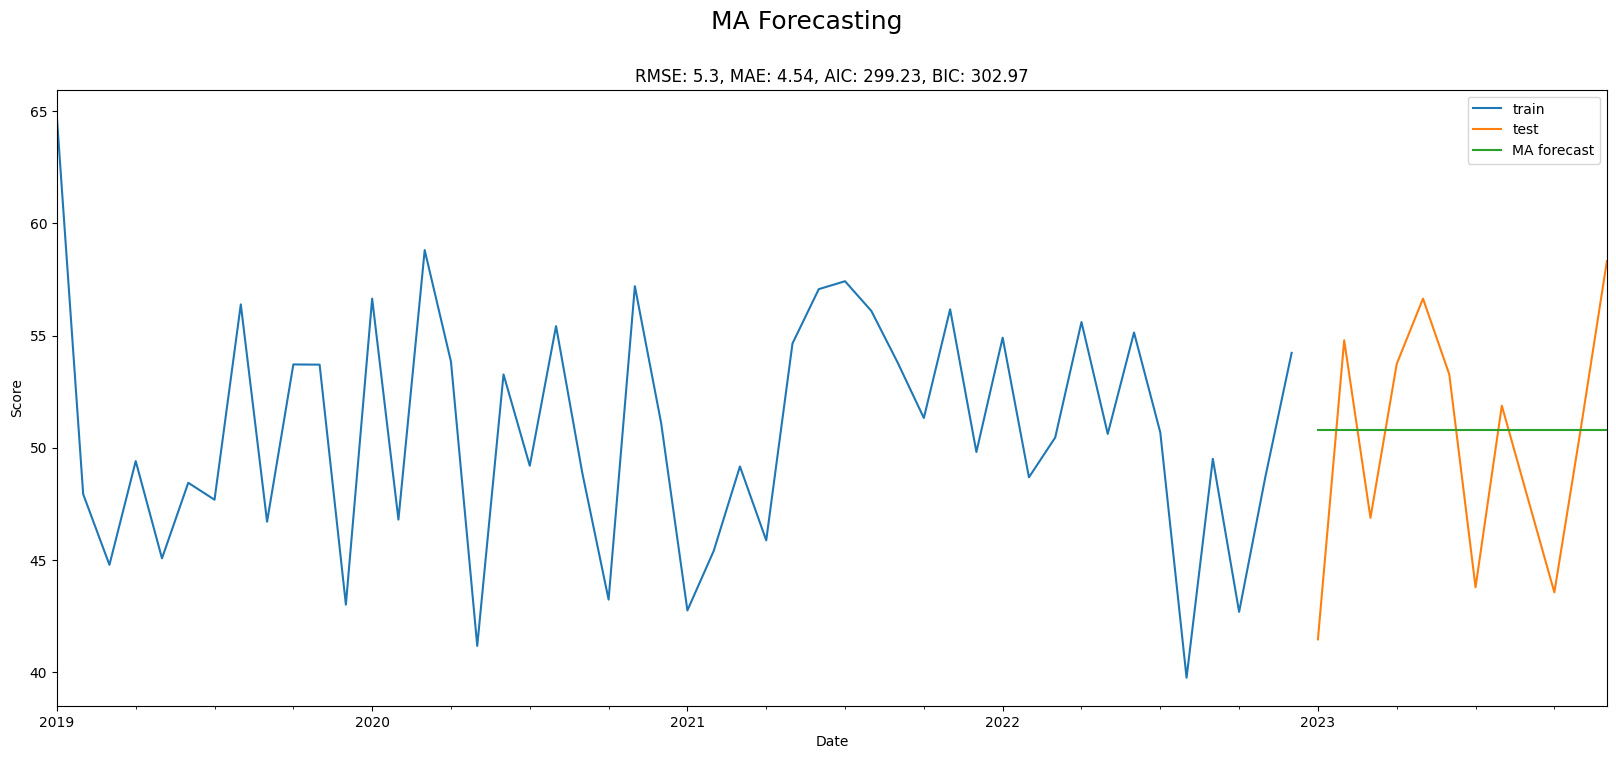

In [28]:
#Edit point 8f-6: Set order to same as edit point 7 answer: Significant non zero lags in the ACF plot

# create MA model with order 2
ma = ARIMA(train.Score,order=(ar_order,d,ma_order)).fit()

test_ma=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ma['predicted']=ma.predict(start=test_ma.index[0],end=test_ma.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ma=round(np.sqrt(mean_squared_error(test_ma.Score,test_ma.predicted)),2)
mae_ma=round(mean_absolute_error(test_ma.Score,test_ma.predicted),2)
aic_ma=round(ma.aic,2)
bic_ma=round(ma.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Score.plot(ax=ax,label='train')
test_ma.Score.plot(ax=ax,label='test')
test_ma.predicted.plot(ax=ax,label='MA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ma)+', MAE: '+str(mae_ma)+', AIC: '+str(aic_ma)+', BIC: '+str(bic_ma))
plt.suptitle("MA Forecasting",fontsize=18)
plt.ylabel('Score')
plt.show()

**Section 8g: SARIMA Models**

First complete the steps to produce an ARIMA model, to determine the ARIMA parameters, then consider this section to find the seasonal paramters

While ARIMA takes into account trend, it doesn't think about seasonality. This is where SARIMA comes in, it models the next step in the time series sequence based off differenced observations, error and differences in seasonal observations. 

If your data does not have seasonality, you will be fine using ARIMA.

<b> Advantages</b> of SARIMA:
<ul>
    <li> Effective at finding patterns in time series data based on differences in observations </li>
    <li> Takes into account seasonality </li>
</ul>

With this model, we still need to pass in the same order as before, but also need to pass in a `seasonal_order` which has the following inputs:

<ul>
    <li><b>P</b>- The seasonal autoregression order</li>
    <li><b>D</b>- The number of differences needed to make the seasonal part of the time series stationary </li>
    <li><b>Q</b>- The seasonal moving average order</li>
    <li><b>M</b>- How many observations to include in a season (i.e. 12 for monthly data with yearly season)</li>
</ul>

So a complete SARIMA will have paramaters (p, d, q) from the ARIMA part and (P, D, Q, M) from the seasonal part.

To find D, P and Q we follow the same process as before, only this time we need to look only at the seasonal part of the data, which we can find using the `seasonal_decompose` function

<Figure size 640x480 with 0 Axes>

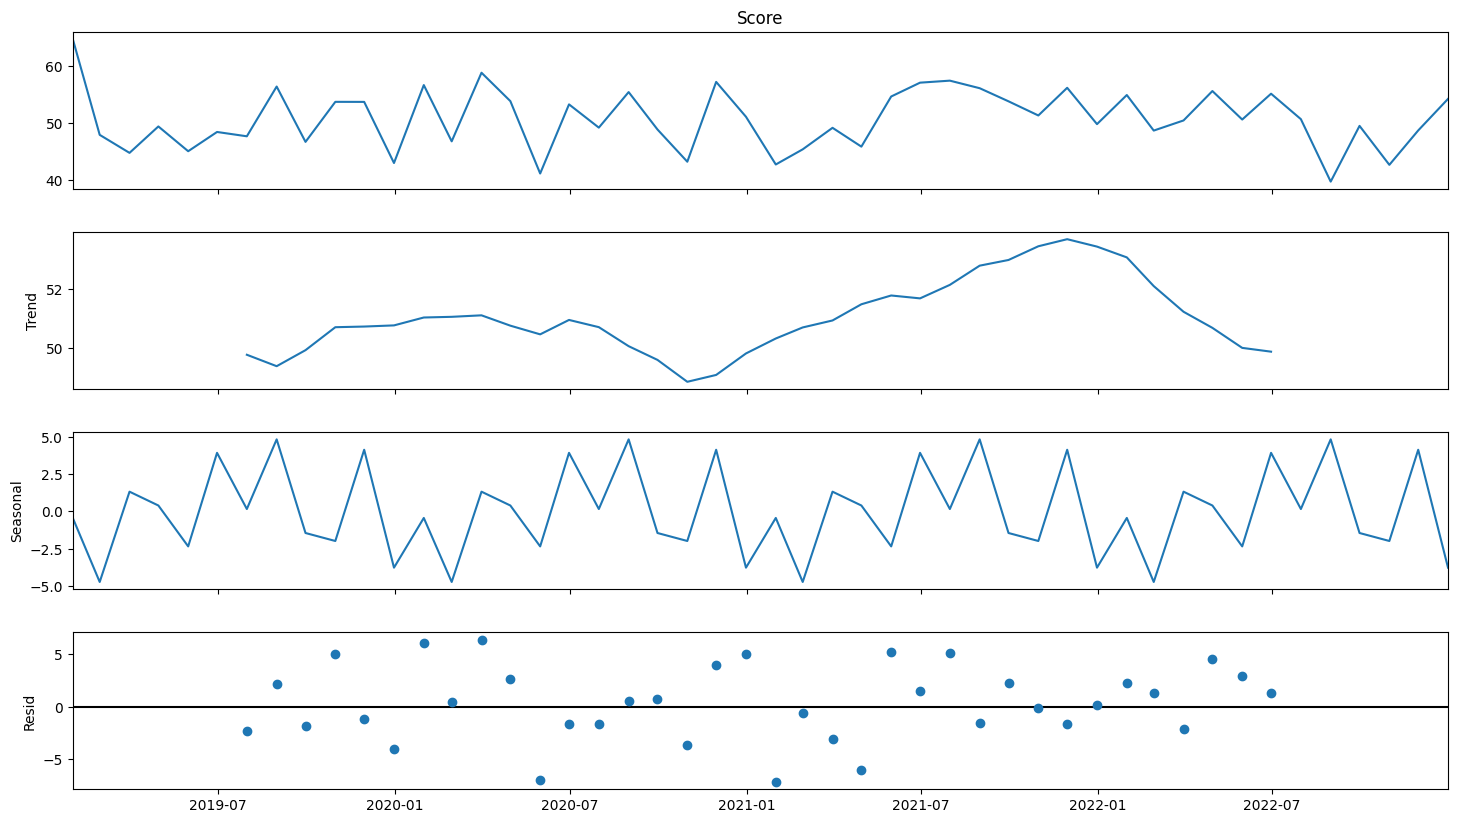

In [29]:
#Edit point 8g-1: adjust seasonal observations as appropriate
decompose = seasonal_decompose(train.Score, period=seasonal_observations)  

fig = plt.figure()  
fig = decompose.plot() 
fig.set_size_inches((16, 9))

For strongly seasonal data you will need to difference your training data seasonally. If not stationary after this you may also need to undertake simple differencing (as we did for the ARIMA model above).

To demonstrate seasonal differencing for the sample code we will assume that only seasonal differencing is required in this situation and take the data and apply seasonal differencing

To seasonally difference you use .diff() with the argument in the brackets being our seasonal period. The sample code has the data as monthly and the seasonal period as a year, so the lags will be 12.

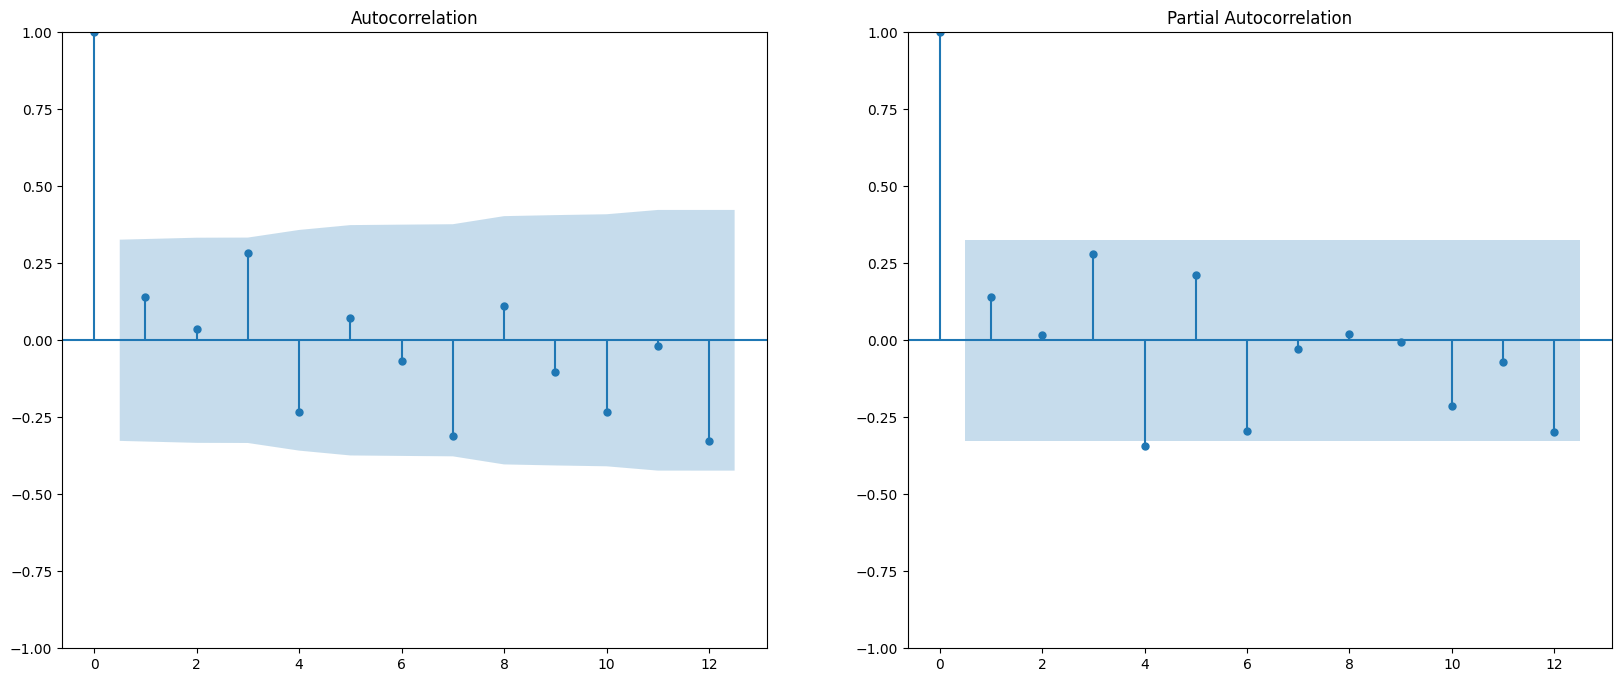

In [30]:
#Edit point 8g-2: adjust seasonal observations as appropriate and produce acf and pacf plots to determine order. It is
# needed to look to at least one seasonal period, so set lags to equal to or greater than the seasonal period.

#If differenced data is used in the ARIMA forecast, this will need to be edited so that .diff is taken of the 
#differenced data used, rather than the raw column
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.Score.diff(seasonal_observations).dropna(),lags=seasonal_observations,ax=ax[0]) 
plot_pacf(train.Score.diff(seasonal_observations).dropna(),lags=seasonal_observations,ax=ax[1], method='ywm') 
plt.show()

We have now undertaken seasonal differencing (D) on our data, so we make seasonal D=1.

We will look to redefine out simple AR MA terms (p, q) as we have differenced again so they may have changed.
<ul>
    <li><b>p</b> look at partial autocorrelation function plot, check if there are significant non-zero lags, to define ar_order, p </li>
    <li><b>q</b> look at the autocorrelation function plot, check if there are significant non-zero lags, to define ma_order, q </li>
</ul>

If the second lag on the ACF plot is negative, we can keep the MA part and drop the AR part (p=0 and q=1 or more). If it is positive we can keep the AR part and drop the MA part (p=1 or more and q=0).

For the seasonal terms of the model, P and Q, we need to look at the PACF and ACF plots respectively but our focus is now on our seasonal period (M). For M, this just comes from how we are defining a seasonal period. If our data is monthly and the seasonal pattern repeats once a year, 12 observations make a year so M = 12. 

Typically you would invesitage multiple repetitions of the seasonal period in the ACF/PACFs. To do this, increase the lags in the ACF and PACF

<ul>
    <li><b>P</b> Look again at the partial autocorrelation function plot for the seaonally differenced data. How many significant multiples of the seasonal period? i.e. starting at lag 12 for monthly data with an annual pattern, how many significant non-zero lags are there? 
    <li><b>Q</b> Look again at the autocorrelation function plot. How many significant multiples of the seasonal period? i.e. starting at lag 12 for monthly data with an annual pattern, how many significant non-zero lags are there? 

We should also check whether the Mth lag (12 for monthly data with an annual pattern) is positive or negative, as this is the Mth lag.

<b>Postive</b> Definitely keep the seasonal AR terms, P = 0 , could /might drop the seasonal MA term (Q=0)

<b>Negative</b>--> Definitely keep the seasonal MA terms, Q = 1, could/ might drop the seasonal AR term (P=0)

/home/omay3/data_development/data_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56006D+00    |proj g|=  1.93466D-01

At iterate    5    f=  2.48685D+00    |proj g|=  1.44951D-02

At iterate   10    f=  2.48449D+00    |proj g|=  9.53295D-04

At iterate   15    f=  2.48442D+00    |proj g|=  9.62773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   4.531D-06   2.484D+00
  F =   2.4844182672094273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


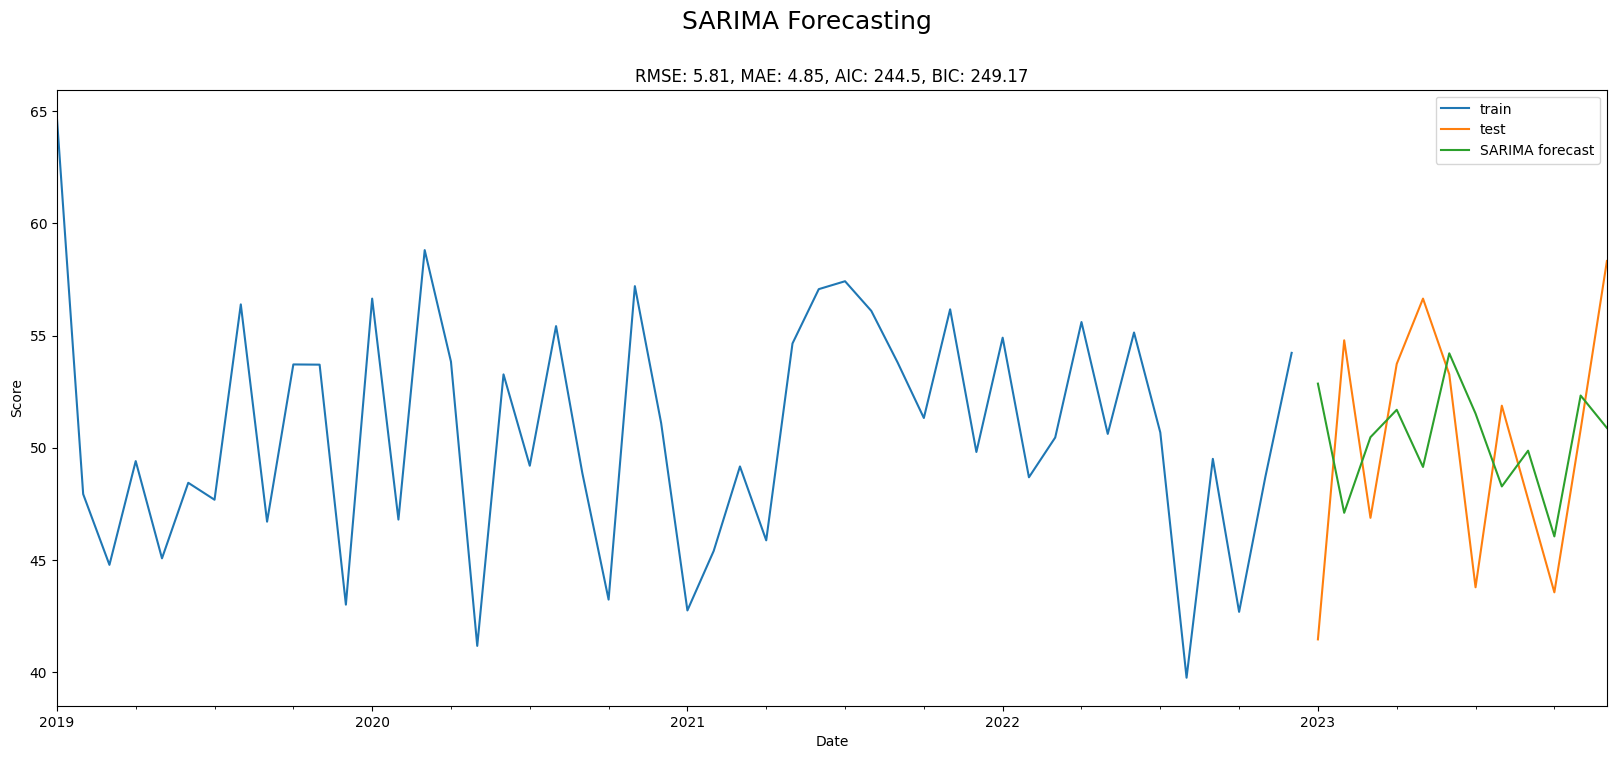

In [31]:
#Edit point 8g-3: From running through the above notes and steps, it should be possible to determine all of the 
#parameters to perform a SARIMA forecast model. Add the values in below, with the ARIMA parameters set to the order
#argument and the seasonal parameters set in the seasonal_order argument

# create SARIMA model with best order and best seasonal_order
sarima = SARIMAX(train.Score,order=(0,1,1),seasonal_order=(0,1,1,12)).fit()

test_sarima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_sarima['predicted']=sarima.predict(start=test_sarima.index[0],end=test_sarima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_sarima=round(np.sqrt(mean_squared_error(test_sarima.Score,test_sarima.predicted)),2)
mae_sarima=round(mean_absolute_error(test_sarima.Score,test_sarima.predicted),2)
aic_sarima=round(sarima.aic,2)
bic_sarima=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Score.plot(ax=ax,label='train')
test_sarima.Score.plot(ax=ax,label='test')
test_sarima.predicted.plot(ax=ax,label='SARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarima)+', MAE: '+str(mae_sarima)+', AIC: '+str(aic_sarima)+', BIC: '+str(bic_sarima))
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Score')
plt.show()

# We may get a warning saying that there are two few observations for the seasonal ARMA. 
# The model will still run, but if you get this warning it is a good idea to get some more observations

**Section 8h: SARIMAX Forecasting**

Edit point 8h: If you are already a whizz with time series forecasting, consider creating a Sarimax forecast from scratch yourself which considers covariates (parallel time series data relating to an exogenous variable that explains what is going on in the data)

**Section 9: Predict the Future**

In [32]:
##Edit point 9 - Apply chosen model to whole dataset
#Reapply chosen (best performing model - by AIC) to full dataset (rather than just train). HWEs chosen here as example. 
#Change parameters to same values as in training model
hwes = ExponentialSmoothing(data_df.Score,seasonal_periods=12 ,trend='add', seasonal='add').fit(optimized=True,smoothing_level=0.5)
forecasts=hwes.predict(start=test_hwes.index[-1],end='31-12-2024')# the start date is the last observation in the data
print(forecasts)

2023-12-31    48.860480
2024-01-31    53.692937
2024-02-29    50.318313
2024-03-31    51.615542
2024-04-30    53.289279
2024-05-31    51.228387
2024-06-30    55.035830
2024-07-31    51.350842
2024-08-31    53.505749
2024-09-30    50.915758
2024-10-31    48.499236
2024-11-30    54.915932
2024-12-31    52.892932
Freq: M, dtype: float64


/home/omay3/data_development/data_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:154: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date_key = Timestamp(key)


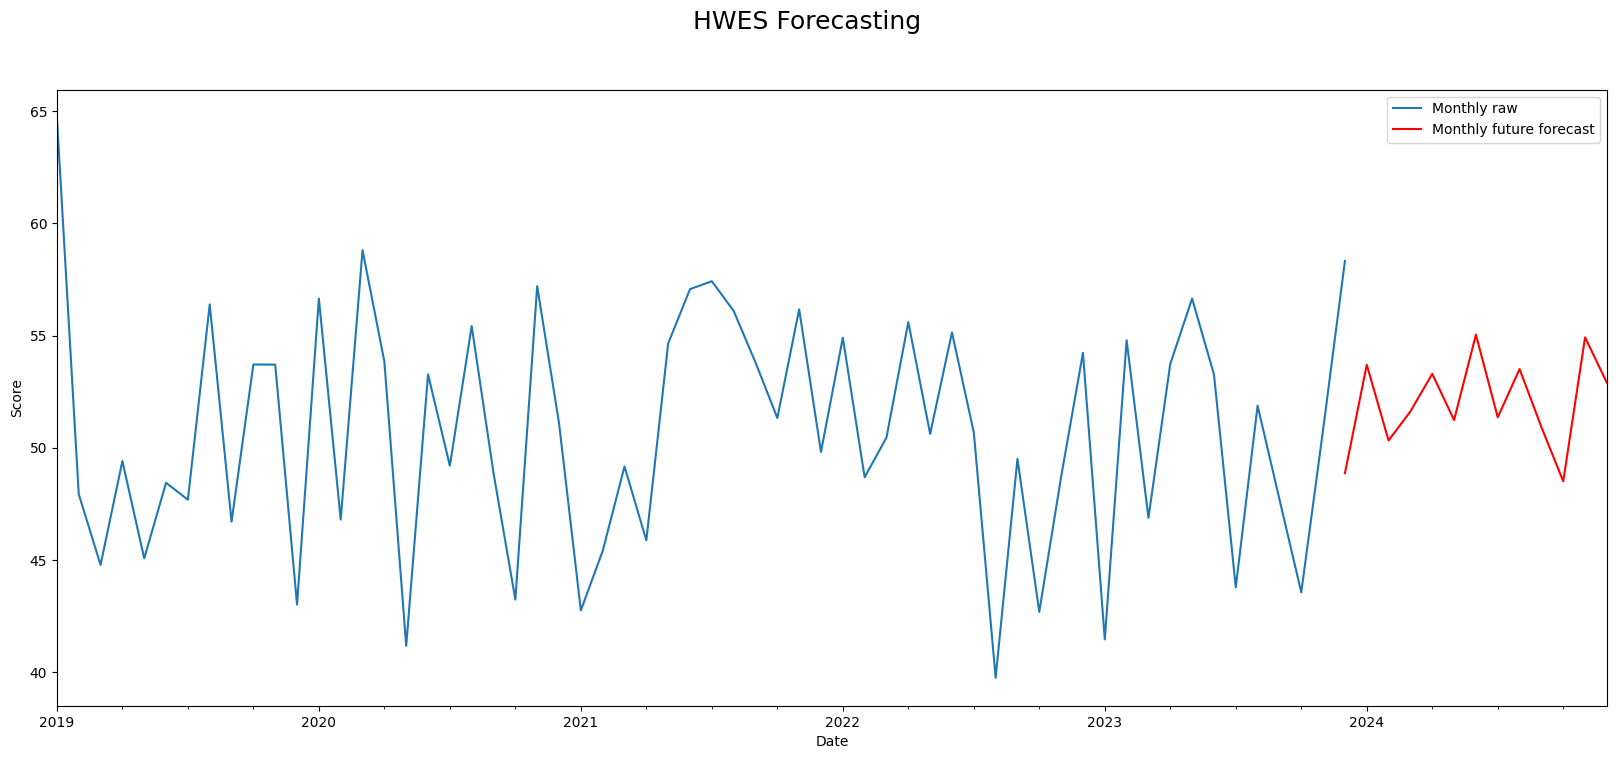

In [33]:
#Plot historical data alonside future forecast
fig, ax = plt.subplots(figsize=(20,8))
data_df.Score.plot(ax=ax,label='Monthly raw')
forecasts.plot(ax=ax, label = 'Monthly future forecast', color = 'red')

plt.legend()
plt.suptitle("HWES Forecasting",fontsize=18)
plt.ylabel('Score')
plt.show()